In [1]:
import numpy as np
import pandas as pd
import glob
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import seaborn
%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
seaborn.set_palette('deep', desat=.6)
np.random.seed(123456)
import sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics

In [2]:
column_names=['date', 'serial_number', 'model', 'capacity_bytes', 'failure','smart_1_raw', 'smart_3_raw',
              'smart_5_raw','smart_9_raw', 'smart_187_raw', 'smart_188_raw', 'smart_196_raw',
              'smart_197_raw', 'smart_198_raw']
files= glob.glob('data_Q1_2016\\2016*.csv')
df= pd.concat([pd.read_csv(i, usecols= column_names) for i in files], ignore_index=True)
df= df[df.capacity_bytes>0]
df['date']= pd.to_datetime(df['date'], errors= 'coerce')
df.to_csv('hard_drive_data_2016.csv')

<b style= "font-size: 120%;">
Dataset
</b>

In [3]:
df= pd.read_csv('hard_drive_data_2016.csv')
df= df.drop('Unnamed: 0', 1)
df= df.sort_values(by='date')

MemoryError: 

In [119]:

column_labels= np.array(['date','serial_number','model','capacity_bytes','failure',
                        'Read_error_rate_raw', 'spin-up_time_raw','Reallocated_sectors_counts_raw', 
                        'Power_On_Hours_raw', 'Reported_Uncorrectable_Errors_raw','Command_Timeout_raw', 
                        'Reallocation_Event_Count_raw','Current_Pending_Sector_Count_raw',
                        'Uncorrectable_Sector_Count_raw'])
df.columns= column_labels

In [120]:
fail= pd.DataFrame(df[df.failure==1]).reset_index()
fail= fail.drop('index', axis= 1)

In [121]:
success= df.groupby(['serial_number']).filter(lambda x: x['failure'].sum()==0) 
succ= pd.DataFrame(success.groupby(['serial_number']).tail(n=1)).reset_index()
succ= succ.drop('index', axis= 1)

In [122]:
df= pd.concat([fail, succ], ignore_index=True)

### Feature reduction

In [124]:
df= df.drop(['date','serial_number', 'model'], axis=1)


In [126]:
df.isnull().sum()
df=df.fillna(0)

In [127]:
def plot_features(feat, std, index, columns):
        num_cols= len(columns)
        plt.figure(figsize= (6,6))
        plt.barh(range(num_cols), feat[index], 
                 color="r", xerr=std[index], align="center")
        plt.xlim(0, 1.2*max(feat))
        plt.yticks(range(num_cols), columns[index])
        plt.xlabel("Feature importance", fontsize=20)
        plt.savefig('feature_selection_with_tree.pdf', bbox_inches= 'tight')
        plt.show()
        print("Top features for selection:")
        for f in range(num_cols):
            print("feature %d (%f)"%(index[f], feat[index[f]]))

In [193]:
def select_features_with_tree(df, estimators= 100):
    y= df.failure.copy()
    X= df.drop('failure', axis= 1) 
    cols= X.columns
    ncols= len(cols)
    forest = ExtraTreesClassifier(n_estimators= estimators, random_state=0, 
                                 max_depth= 10, min_samples_leaf=5)
    forest.fit(X,y)
    features= forest.feature_importances_
   
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(features)[::-1] 
    model= SelectFromModel(forest, prefit=True)
    columns= [j for i, j in enumerate(cols)  if (model.get_support()[i]== True)]
    X_redu= pd.DataFrame(model.transform(X), columns= columns)
    y_redu= y
    plot_features(features, std, indices, cols)
    return X_redu, y_redu

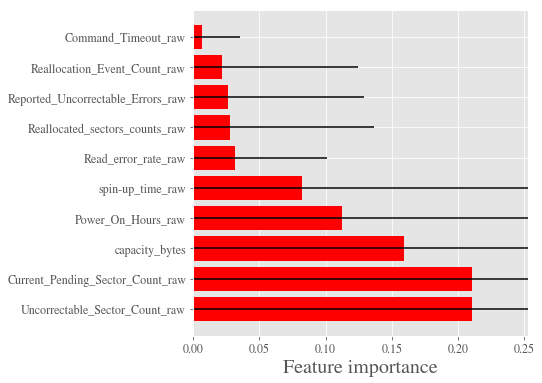

Feature ranking:
feature 9 (0.210510)
feature 8 (0.210169)
feature 0 (0.159472)
feature 4 (0.112617)
feature 2 (0.082169)
feature 1 (0.031763)
feature 3 (0.028125)
feature 5 (0.026353)
feature 7 (0.021984)
feature 6 (0.006838)


In [194]:
X_reduced, y_reduced= select_features_with_tree(df, estimators= 100)

In [195]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_reduced, y_reduced, test_size=0.3, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape) 

(44851, 4)
(19223, 4)
(44851,)
(19223,)


## Fraction of failed and working disks: 
### (Unbalanced sample)

In [196]:
y_train.index= X_train.index
unbalanced_set= pd.concat([X_train, y_train], axis=1)

In [197]:
sd= np.shape(unbalanced_set.ix[unbalanced_set.failure==0])[0]
fd= np.shape(unbalanced_set.ix[unbalanced_set.failure==1])[0]
tot= sd+fd
print("working: ",sd," | failed: ",fd)
print ('Fraction of failed disks:', fd/tot, '%')
print ('Fraction of working disks:', sd/tot, '%')

working:  44616  | failed:  235
Fraction of failed disks: 0.005239571024057435 %
Fraction of working disks: 0.9947604289759425 %


C:\Users\TCS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


<b style= "font-size: 140%;">
Oversampling:
</b>



In [198]:
def get_oversampled_set(df, target_variable= 'failure', frac_minority= 0.4, frac_mayority=0.6):
    minority_class= df.ix[df[target_variable]== 1]
    mayority_class= df.ix[df[target_variable]== 0]
    num_elements= (frac_minority/frac_mayority)*np.shape(mayority_class)[0]
    minority_class= minority_class.sample(n=int(num_elements), replace=True, random_state= 123456)
    new_sample= pd.concat([minority_class, mayority_class])
    
    maj= mayority_class.shape[0] 
    print ('Fraction of failed disks after oversampling:', num_elements/(num_elements+maj) )
    print ('Fraction of working disks after oversampling:', maj/(num_elements+maj) )
    print("working: ",maj," | failed: ",int(num_elements))
    return new_sample
    

In [199]:
oversampled_set= get_oversampled_set(unbalanced_set)


Fraction of failed disks after oversampling: 0.4
Fraction of working disks after oversampling: 0.6
working:  44616  | failed:  29744


In [200]:
X_oversampled= oversampled_set.drop('failure', axis=1)
y_oversampled= oversampled_set.failure.copy()

In [201]:
model = RandomForestClassifier(n_estimators=200, oob_score=True, min_samples_leaf=5, max_depth=10)

In [202]:
model.fit(X_oversampled, y_oversampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [203]:
from sklearn.metrics import accuracy_score
prediction= model.predict(X_test)
print("Accuracy of model: ",accuracy_score(y_test, prediction))

Accuracy of model:  0.989335691619


In [204]:
pred_probabilities = model.predict_proba(X_test)


### Area under the curve ROC curves

In [205]:
AUC= metrics.roc_auc_score(y_test, pred_probabilities[:,1])

In [206]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_probabilities[:,1])

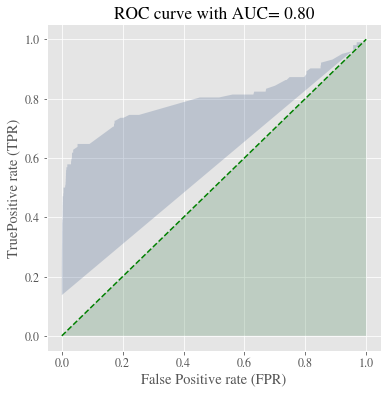

In [207]:
fig= plt.figure(figsize=(6,6))
ax= fig.add_subplot(111)
ax.fill(fpr, tpr, alpha= 0.3)
ax.fill_between(np.linspace(0,1, 10), np.linspace(0,1,10), alpha= 0.3)
ax.plot([0,1], [0,1], 'g--' )
ax.set_title('ROC curve with AUC= %.2f'%AUC)
ax.set_xlabel('False Positive rate (FPR)')
ax.set_ylabel('TruePositive rate (TPR)');
plt.savefig('ROC_oversampling.pdf', bbox_inches='tight')

### Precision and Recall

In [208]:
precision = metrics.precision_score(y_test, prediction)
recall = metrics.recall_score(y_test, prediction)
print ('True positive rate:', recall)
print ('False positive rate:', precision)

True positive rate: 0.5
False positive rate: 0.248780487805


In [191]:
metrics.confusion_matrix(y_test, prediction)

array([[18984,   137],
       [   52,    50]], dtype=int64)

In [192]:
print ('failed disks:', np.shape(y_test[y_test==1]) )
print ('working disks:', np.shape(y_test[y_test==0]) )

failed disks: (102,)
working disks: (19121,)


<b style= "font-size: 140%;">
Undersampling:
</b>


In [149]:
def get_subsampled_set(df, target_variable= 'failure', frac_minority= 0.4, frac_mayority=0.6):
    minority_class= df.ix[df[target_variable]== 1]
    mayority_class= df.ix[df[target_variable]== 0]
    num_elements= (frac_mayority/frac_minority)*np.shape(minority_class)[0]
    mayority_class= mayority_class.sample(n=int(num_elements), random_state= 123456)
    new_sample= pd.concat([minority_class, mayority_class])
    minu= minority_class.shape[0] 
    print ('Fraction of failed disks after subsampling:', minu/(num_elements+minu) )
    print ('Fraction of working disks after subsampling:',(num_elements/(num_elements+minu)))
    print("working: ",int(num_elements)," | failed: ",minu)
    return new_sample

In [150]:
subsampled_set= get_subsampled_set(unbalanced_set)

Fraction of failed disks after subsampling: 0.4
Fraction of working disks after subsampling: 0.5999999999999999
working:  352  | failed:  235


In [151]:
X_subsampled= subsampled_set.drop('failure', axis=1)
y_subsampled= subsampled_set.failure.copy()

In [152]:
model1 = RandomForestClassifier(n_estimators=200, 
                               oob_score=True, 
                               min_samples_leaf=5, 
                               max_depth=10)

In [153]:
model1.fit(X_subsampled, y_subsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [154]:
from sklearn.metrics import accuracy_score
prediction1= model1.predict(X_test)
print("Accuracy of model: ",accuracy_score(y_test, prediction))

Accuracy of model:  0.988347292306


In [155]:
pred_probabilities1 = model1.predict_proba(X_test)

### Area under the curve ROC curves

In [156]:
AUC1= metrics.roc_auc_score(y_test, pred_probabilities1[:,1])

In [157]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_probabilities1[:,1])

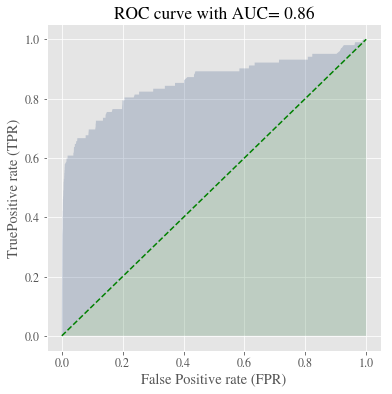

In [158]:
fig= plt.figure(figsize=(6,6))
ax= fig.add_subplot(111)
ax.fill(fpr1, tpr1, alpha= 0.3)
ax.fill_between(np.linspace(0,1, 10), np.linspace(0,1,10), alpha= 0.3)
ax.plot([0,1], [0,1], 'g--' )
ax.set_title('ROC curve with AUC= %.2f'%AUC1)
ax.set_xlabel('False Positive rate (FPR)')
ax.set_ylabel('TruePositive rate (TPR)');
plt.savefig('ROC_subsampling.pdf', bbox_inches='tight')

### Precision and Recall

In [159]:
precision1 = metrics.precision_score(y_test, prediction1)
recall1 = metrics.recall_score(y_test, prediction1)
print ('True positive rate:', recall1)
print ('False positive rate:', precision1)

True positive rate: 0.607843137255
False positive rate: 0.0998389694042


In [160]:
metrics.confusion_matrix(y_test, prediction)

array([[18948,   173],
       [   51,    51]], dtype=int64)